In [1]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting,image
from nilearn.image import load_img, math_img
from nilearn.glm.first_level import FirstLevelModel
import pandas as pd
import numpy as np
import os
from os.path import join
import glob
from scipy.stats import norm

# define directory
myDir = {
    'bids': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/BIDS/',
    'prep': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/BIDS/derivatives/',
    'fs': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/BIDS/derivatives/freesurfer/',
    'fig': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/Figs/',
    'res': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/Results/',
    'ana': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/Ana_code/',
    'templates': '/projectnb2/viscog01/Wen/IBL_TI_fMRI/Ana_code/templates/',
}
# os.environ['SUBJECTS_DIR'] = '/projectnb2/viscog01/Wen/IBL_TI_fMRI/BIDS/derivatives/freesurfer'

In [19]:
subjlist = '/projectnb2/viscog01/Wen/IBL_TI_fMRI/BIDS/subj_all.txt'
with open(subjlist, 'r') as file:
    all_subj = file.read().splitlines()
# print(all_subj)

func_task = 'MT'
contrast_name = 'Motion_Static'

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting, image
from os.path import join

def plot_all(subject_files, thresh_p, cluster_vox_num, hc):
    # Calculate the number of rows and columns for subplots
    c = int(np.ceil(np.sqrt(len(subject_files))))
    r = int(np.ceil(len(subject_files) / c))

    fig, axes = plt.subplots(nrows=r, ncols=c)

    for cidx in range(len(subject_files)):
        plotting.plot_glass_brain(
            image.load_img(subject_files[cidx]),
            colorbar=True,
            threshold=norm.ppf(1 - thresh_p / 2),
            title=f'{all_subj[cidx]} p<{thresh_p}',
            axes=axes[cidx],
            plot_abs=False,
            display_mode="z",
        )

    # Add a title to the entire figure
    fig.suptitle("First level t_map")

    plt.savefig(join(myDir['fig'], f'{func_task}_{contrast_name}_{hc}_thresh{thresh_p}_clusterVoxN{cluster_vox_num}_all_1st.png'))
    plt.show()


/scratch/3755277.1.virtualgl/ipykernel_991003/3684070634.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


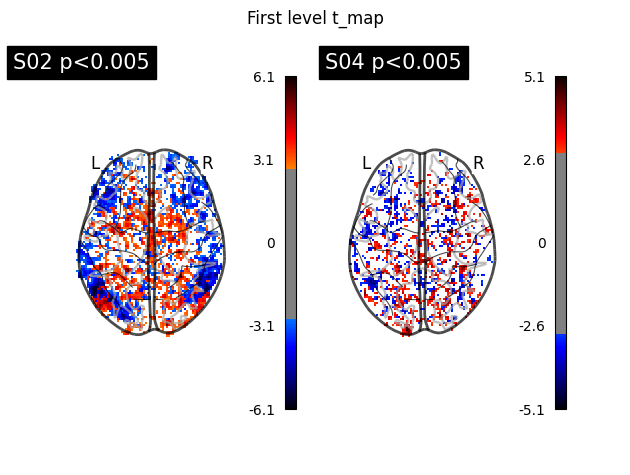

In [21]:
thresh_p_values = [0.005]
cluster_vox_num_values = [3]
hc_values = ['fpr']

for thresh_p in thresh_p_values:
    for cluster_vox_num in cluster_vox_num_values:
        for hc in hc_values:
            subject_files = glob.glob(join(myDir['res'],f'*{func_task}_{contrast_name}_{hc}_thresh{thresh_p}_clusterVoxN{cluster_vox_num}.nii.gz'))
            plot_all(subject_files,thresh_p,cluster_vox_num,hc)

In [5]:
# define design matrix: one-sample ttest

import pandas as pd

design_matrix = pd.DataFrame([1] * len(subject_files), columns=["intercept"])

print(design_matrix)

   intercept
0          1
1          1


In [ ]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(
    subject_files, design_matrix=design_matrix
)
z_map = second_level_model.compute_contrast(output_type="z_score")


p_val = 0.01
display = plotting.plot_glass_brain(
    z_map,
    threshold=norm.isf(p_val),
    colorbar=True,
    display_mode="z",
    plot_abs=False,
    title=f"{func_task}: 2nd level\n(unc p<{p_val})",
    figure=plt.figure(figsize=(5, 5)),
)
plotting.show()


/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 3.1987080407158652. But, you have given threshold=inf.
  warnings.warn(


The FDR=.05 threshold is inf


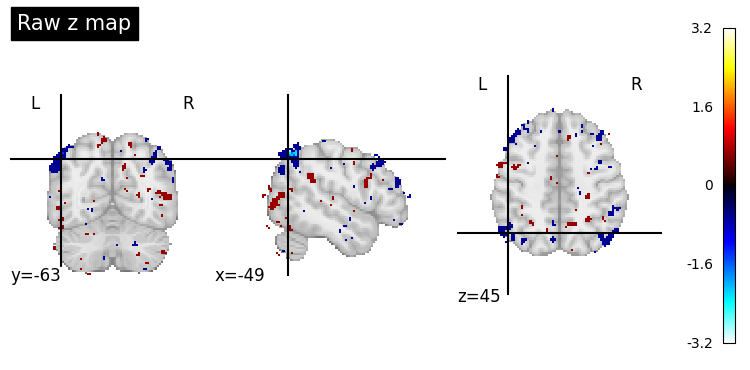

In [7]:
from nilearn.glm import threshold_stats_img

thresholded_map1, threshold1 = threshold_stats_img(
    z_map, alpha=0.05,height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold1:.3g}")

from nilearn import plotting

display = plotting.plot_stat_map(z_map, title="Raw z map")

In [39]:
# One key difference between SecondLevelModel and non_parametric_inference/ permuted_ols is that the one-sample test in non_parametric_inference/permuted_ols assumes that the distribution is symmetric about 0, which is is weaker than the SecondLevelModels assumption that the null distribution is Gaussian and centered about 0.

from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    subject_files,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=500,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=2,
    threshold=0.05
)

/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


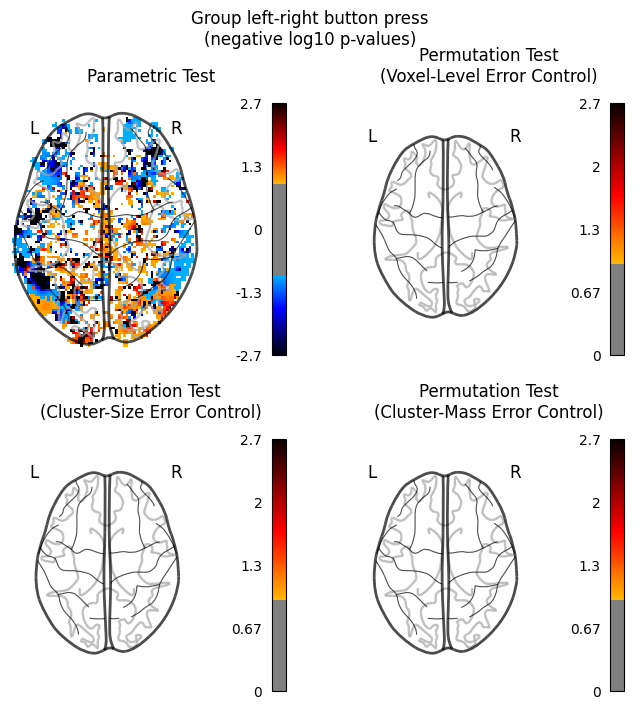

In [48]:
import itertools

threshold = 1  # p < 0.1
vmax = 2.69  # ~= -np.log10(1 / 500)

cut_coords = [0]
IMAGES = [
    out_dict["t"],
    out_dict["logp_max_t"],
    out_dict["logp_max_size"],
    out_dict["logp_max_mass"],
]
TITLES = [
    "Parametric Test",
    "Permutation Test\n(Voxel-Level Error Control)",
    "Permutation Test\n(Cluster-Size Error Control)",
    "Permutation Test\n(Cluster-Mass Error Control)",
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
for img_counter, (i_row, j_col) in enumerate(
    itertools.product(range(2), range(2))
):
    ax = axes[i_row, j_col]
    plotting.plot_glass_brain(
        IMAGES[img_counter],
        colorbar=True,
        vmax=vmax,
        display_mode="z",
        plot_abs=False,
        cut_coords=cut_coords,
        threshold=threshold,
        figure=fig,
        axes=ax,
    )
    ax.set_title(TITLES[img_counter])
fig.suptitle("Group left-right button press\n(negative log10 p-values)")
plt.show()

/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


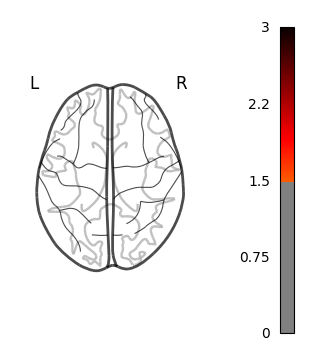

In [36]:
plotting.plot_glass_brain(
        out_dict["logp_max_t"],
        colorbar=True,
        vmax=3,
        display_mode="z",
        plot_abs=False,
        cut_coords=[0],
        threshold=1.5,
    )
plotting.show()